# Week 11: An Attempt on Poly-Square Mapping
A naive attempt achieving poly-square mapping[[1]](#ref-1)

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - More Examples](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [1]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges
from util.mesh.triangle.R2 import make_clockwise_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.mapping_poly_square import Liu_2017

# Visualization
import pyvista as pv
from pyvista import examples

from scipy.spatial import Delaunay

C:\Tool\Env\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<a name='1'></a>
## 1 - Test Example

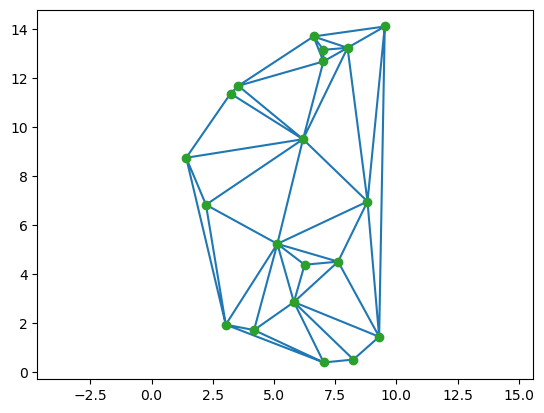

In [2]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=10
points[:, 1]*=15

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

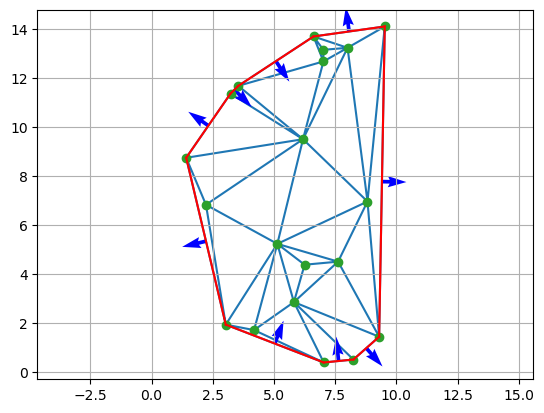

In [3]:
# edges = triangle_edges(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

plt.axis('equal')
plt.grid() 
plt.show()


In [4]:
faces=tri.simplices.copy()
vertices=points.copy()
boundary_edges = retrieve_boundary_edges(tri.simplices)
lambda_=5

<a name='2'></a>
## 2 - The Loss Function

$$Loss = E^D + \lambda * E^B$$

$E^D$ is the distortion term. A EMIPS energy, which is similar to MIPS energy[[2]](#ref-2), is used.

$$E^D = \sum e^{\frac{s1}{s2}+\frac{s2}{s1}}$$

where $s1$ and $s2$ are the singular values of the Jacobian matrix.

$E^B$ is the alignment term. The algorithm only measure the alignment of boundary edges.

$$E^B = \sum_{i \in b} L_i(||n_i||-1)$$

$\lambda$ is the hyper-parameter to balance the two terms.

In [12]:
def energy(x):
    X = x.reshape((v_num, 2))
    
    EB = 0
    for edge in boundary_edges:
        A, B = X[edge[0]], X[edge[1]]
        EB += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
        
    ED = 0
    for face in faces:
        A, B, C = X[face[0]], X[face[1]], X[face[2]]
        A_, B_, C_ = vertices[face[0]], vertices[face[1]], vertices[face[2]]
        
        before = np.column_stack([B_-A_,C_-A_])
        after = np.column_stack([B-A,C-A])
        J = after @ np.linalg.inv(before)
        
        u, s, v = np.linalg.svd(J)
        s1, s2 = s[0], s[1]
        ED += np.exp(s1/s2 + s2/s1)
    return lambda_*EB+ED

In [79]:
x0 = np.ravel(vertices)
res = minimize(energy, x0, options = {'maxiter': 10}
#                , method='BFGS'
              )
vertices_opt = res.x.reshape((v_num,2))

<a name='3'></a>
## 3 - Result

In [110]:
class Liu_2017:
    def __init__(self, vertices, faces, lambda_=5, max_iter = 30):
        self.max_iter = max_iter
        self.vertex_num = vertices.shape[0]
        self.vertices = vertices
        self.faces = faces
        self.lambda_=lambda_
        
        self.solution = self.vertices.copy()
        self.boundary_edges = retrieve_boundary_edges(faces)
        
    def loss(self, x):
        X = x.reshape((self.vertex_num, 2))
        
        # Boundary edges alignment
        EB = 0
        for edge in self.boundary_edges:
            A, B = X[edge[0]], X[edge[1]]
            EB += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
            
        # Distortion term
        ED = 0
        for face in self.faces:
            A, B, C = X[face[0]], X[face[1]], X[face[2]]
            A_, B_, C_ = self.vertices[face[0]], self.vertices[face[1]], self.vertices[face[2]]

            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J = after @ np.linalg.inv(before)

            u, s, v = np.linalg.svd(J)
            s1, s2 = s[0], s[1]
            ED += np.exp(s1/s2 + s2/s1)
            
        return self.lambda_*EB+ED
    
    def optimize(self):
        x0 = np.ravel(self.solution)
        self.res = minimize(self.loss, x0, options = {'maxiter': self.max_iter})
        self.solution = self.res.x.reshape((self.vertex_num, 2))
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution)
        self.res = minimize(self.loss, x0, options = {'maxiter': 1})
        self.solution = self.res.x.reshape((self.vertex_num, 2))
        
    def visualize_initial(self, show_boundary = False):
        plt.plot(self.vertices[:,0], self.vertices[:,1], 'o', color='green')
        plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='orange')
        if show_boundary:
            for edge in self.boundary_edges:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'y-')
        plt.axis('equal')
        plt.legend()
#         plt.show()
        
    def visualize_solution(self, show_boundary = False):
        plt.plot(self.solution[:,0], self.solution[:,1], 'o', color='blue')
        plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, label='Transformed Mesh', color='blue')
        if show_boundary:
            for edge in self.boundary_edges:
                plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'r-')
        plt.axis('equal')
        plt.legend()
#         plt.show()
        
    def visualize(self):
        self.visualize_initial()
        self.visualize_solution()

In [9]:
testtt = Liu_2017(points.copy(), tri.simplices, max_iter = 30)

In [13]:
x0 = np.ravel(vertices)
res = minimize(energy, x0, options = {'maxiter': 30}
#                , method='BFGS'
              )
vertices_opt = res.x.reshape((v_num,2))

In [10]:
testtt.optimize()

In [14]:
testtt.solution == vertices_opt

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

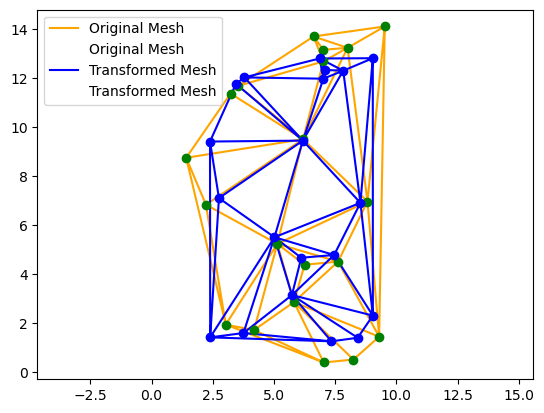

In [11]:
testtt.visualize()

In [91]:
testtt.solution == vertices_opt

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [66]:
testtt.solution

array([[ 2.245588  , 10.88402202],
       [ 2.66050876,  0.87606805],
       [ 9.68207324,  3.25981165],
       [ 0.9831748 ,  9.24840121],
       [ 4.86204822,  4.78770152],
       [ 6.44988119,  5.67920795],
       [ 1.03426037,  1.63155713],
       [ 2.69456415,  0.14068159],
       [ 5.33452126,  6.1668344 ],
       [ 6.0221891 ,  7.04205119],
       [ 0.23714196, 13.81660498],
       [ 5.2655293 ,  7.89074103],
       [ 8.44191769,  1.35572656],
       [ 3.47037029,  5.68954046],
       [ 6.50731539, 11.4363781 ],
       [ 4.71601436,  2.51857787],
       [ 0.08962004,  2.14499138],
       [ 1.28101016, 11.95944162],
       [ 9.68715352,  5.40220757],
       [ 0.67102942,  4.08822449]])

In [67]:
vertices_opt

array([[ 2.245588  , 10.88402202],
       [ 2.66050877,  0.87606806],
       [ 9.70243307,  3.25359663],
       [ 0.98317479,  9.2484012 ],
       [ 4.86204822,  4.78770152],
       [ 6.44988118,  5.67920795],
       [ 1.03426038,  1.63155712],
       [ 2.68745229,  0.18575444],
       [ 5.33452125,  6.16683438],
       [ 6.02218909,  7.0420512 ],
       [ 0.20198714, 13.79202791],
       [ 5.2655293 ,  7.89074101],
       [ 8.45840541,  1.33175367],
       [ 3.47037029,  5.68954046],
       [ 6.52508535, 11.45647576],
       [ 4.71601436,  2.51857787],
       [ 0.13527654,  2.13011459],
       [ 1.28101016, 11.95944162],
       [ 9.62914616,  5.40667879],
       [ 0.67102941,  4.08822448]])

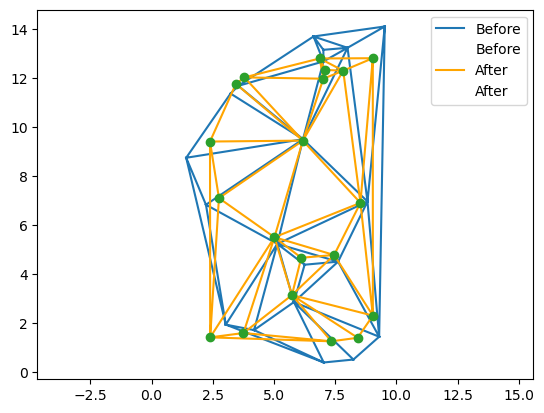

In [15]:
plt.triplot(points[:,0], points[:,1], tri.simplices, label='Before')
plt.triplot(vertices_opt[:,0], vertices_opt[:,1], tri.simplices, color='orange', label='After')
plt.plot(vertices_opt[:,0], vertices_opt[:,1], 'o')
plt.axis('equal')
plt.legend()
plt.show()

<a name='4'></a>
## 4 - More Examples

In [1]:
edges = retrieve_all_edges(tri.simplices)
i=-1

NameError: name 'retrieve_all_edges' is not defined

In [ ]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')

i+=1
plt.plot(points[np.array(edges[i]), 0], points[np.array(edges[i]), 1], 'r-')
plt.axis('equal')
plt.grid() 
plt.show()
print("edge: ", i)
print("vertices index: ", edges[i])


In [235]:
for idx, face in enumerate(new_faces):
    if 18 in face:
        print(face, idx)

[ 0 18 19] 23
[ 0 14 18] 24
[16 18 14] 25
[ 7 18 16] 26


In [236]:
new_faces = np.delete(new_faces, 23, axis=0)

In [237]:
for idx, face in enumerate(new_faces):
    if 18 in face:
        print(face, idx)

[ 0 14 18] 23
[16 18 14] 24
[ 7 18 16] 25


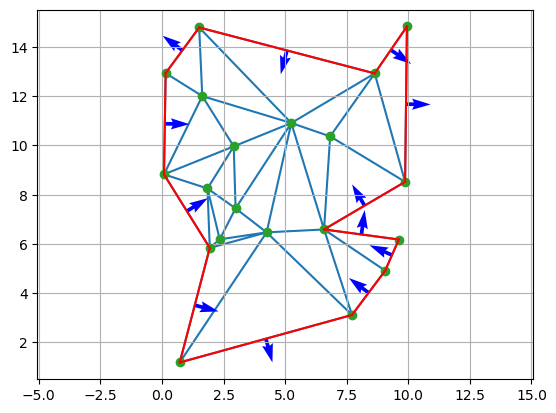

In [287]:
boundary_edges = retrieve_boundary_edges(new_faces)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], new_faces)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

plt.axis('equal')
plt.grid() 
plt.show()

In [462]:
faces = new_faces
boundary_edges = retrieve_boundary_edges(new_faces)
x0 = np.ravel(vertices)
res = minimize(energy, x0, options = {'maxiter': 20}
#                , method='BFGS'
              )
vertices_opt = res.x.reshape((v_num,2))

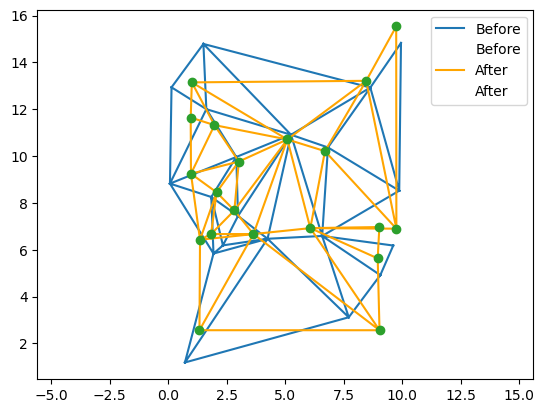

In [463]:
plt.triplot(points[:,0], points[:,1], new_faces, label='Before')
plt.triplot(vertices_opt[:,0], vertices_opt[:,1], new_faces, color='orange', label='After')
plt.plot(vertices_opt[:,0], vertices_opt[:,1], 'o')
plt.axis('equal')
plt.legend()
plt.show()

Some other non-convex examples

In [317]:
from util.util import v_triangle_2D

In [311]:
# 100 random points
x = np.linspace(-1, 1, v_num)
y = np.power(x, 2) + np.random.uniform(-0.5, 0.5, v_num)
test_points = np.vstack([x,y]).T

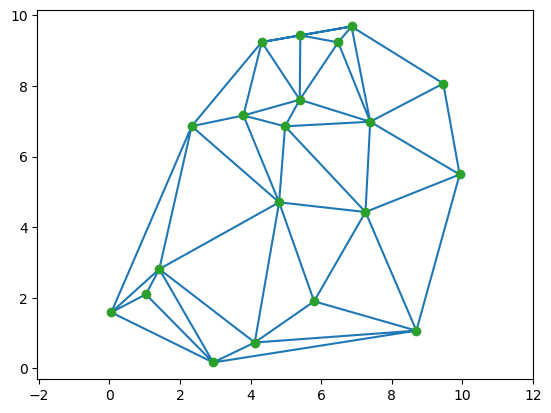

In [663]:
test_points = np.random.rand(v_num, 2)*10
# test_points[:, 0]*=5
# test_points[:, 1]*=2

# Delaunay algorithm to triangulate the mesh
test_tri = Delaunay(test_points)
make_clockwise_2D(points, test_tri.simplices)

plt.triplot(test_points[:,0], test_points[:,1], test_tri.simplices)
plt.plot(test_points[:,0], test_points[:,1], 'o')
plt.axis('equal')
plt.show()

In [764]:
i=-1

triangle index:  6


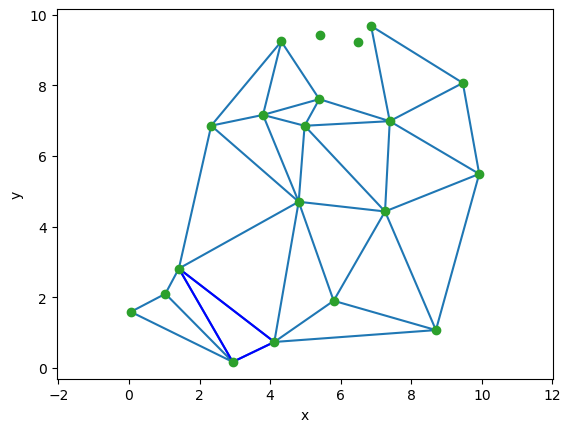

In [771]:
i+=1
A, B, C = test_points[test_tri.simplices[i]]
print("triangle index: ", i)
v_triangle_2D(A,B,C)
plt.triplot(test_points[:,0], test_points[:,1], test_tri.simplices)
plt.plot(test_points[:,0], test_points[:,1], 'o')
plt.axis('equal')
plt.show()



In [763]:
test_tri.simplices = np.delete(test_tri.simplices, 13, axis=0)

In [781]:
faces = test_tri.simplices
boundary_edges = retrieve_boundary_edges(test_tri.simplices)
x0 = np.ravel(test_points)
res = minimize(energy, x0, options = {'maxiter': 20}
#                , method='BFGS'
              )
vertices_opt = res.x.reshape((v_num,2))

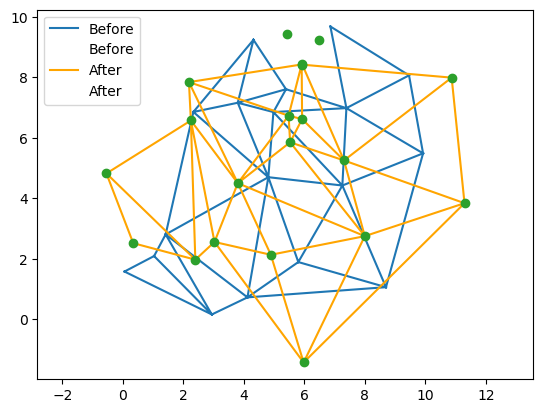

In [782]:
plt.triplot(test_points[:,0], test_points[:,1], test_tri.simplices, label='Before')
plt.triplot(vertices_opt[:,0], vertices_opt[:,1], test_tri.simplices, color='orange', label='After')
plt.plot(vertices_opt[:,0], vertices_opt[:,1], 'o')
plt.axis('equal')
plt.legend()
plt.show()

## 5 - Problems

+ **Flip-over**: As the energy does not contain any methods to prevent **fliping over** (The reference paper adopted a global strategy to subdivide the mesh and preserve features. This algorithm is a local step), it is obvious that when the iteration reach a certain number, the triangle might happen to decay to a line or flip.
+ **Non-convex boundary**: As it is shown above, the method works very well with 2D triangular mesh with convex boundary. But for those with non-convex boundary, it significantly distort
+ **The need of subdivision of single triangle**: The method can not deal with mesh that consists of one triangle. As it is shown on the last example, if there exists cusps in the mesh, the algorithm fail to handle it and may need to subdivide the triangles.

<a name='6'></a>
## 6 - Reference

<a name='ref-1'></a>
1. [Liu C, Yu W, Chen Z, et al. Distributed poly-square mapping for large-scale semi-structured quad mesh generation[J]. Computer-Aided Design, 2017, 90: 5-17.](https://www.sciencedirect.com/science/article/pii/S0010448517300714?casa_token=JiylsQjWSkQAAAAA:RnbFGyT8qf-EsojvYlxX-if7lhZx1TwO8i0XjTwlYa-y1AqIkVAOJHRwOm5VrxhaAUkET4LSkRc)
<a name='ref-2'></a>
1. [Hormann K, Greiner G. MIPS: An efficient global parametrization method[J]. Curve and Surface Design: Saint-Malo 1999, 2000: 153-162.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=02e4f09c9a6d0d770d31c9289d30b7b4e9b5d974)